
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# Normalizing data - following Section 4?/hw4

# store the names of the columns first
columns = X_train.columns.values.tolist()

#instantiate scaler
scaler = MinMaxScaler()

# Normalize X_train - fit it on X_train
X_train = scaler.fit_transform(X_train)  # turns it into a numpy array
X_train = pd.DataFrame(X_train, columns = columns)   # need to turn it back into a dataframe and have same column names

# Normalize X_test - already fitted on X_train, only need to transform here
X_test = scaler.transform(X_test)  # turns it into a numpy array
X_test = pd.DataFrame(X_test, columns = columns)   # need to turn it back into a dataframe and have same column names

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [5]:
# instantiate and fit the model
unreg_log = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 1000).fit(X_train,y_train)

# Predict
y_pred_train_ulog = unreg_log.predict(X_train)
y_pred_test_ulog = unreg_log.predict(X_test)

# Score
train_score_ulog = accuracy_score(y_train, y_pred_train_ulog)*100
test_score_ulog = accuracy_score(y_test, y_pred_test_ulog)*100

print("Training Set Accuracy:",str(train_score_ulog)+'%')
print("Testing Set Accuracy:",str(test_score_ulog)+'%')

Training Set Accuracy: 100.0%
Testing Set Accuracy: 78.1456953642384%


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [6]:
# Using regularization and cross validation

reg_log_cv = LogisticRegressionCV(cv = 10, solver="liblinear",  multi_class='ovr', penalty = 'l1', max_iter = 100000)
reg_log_cv.fit(X_train, y_train)  # fit on train data

# Predict
y_train_pred_CV = reg_log_cv.predict(X_train)
y_test_pred_CV = reg_log_cv.predict(X_test)

# Score
train_score_cv = accuracy_score(y_train, y_train_pred_CV)*100
test_score_cv = accuracy_score(y_test, y_test_pred_CV)*100

print("CV Training Set Accuracy:",str(train_score_cv)+'%')
print("CV Testing Set Accuracy:",str(test_score_cv)+'%')

CV Training Set Accuracy: 91.01497504159734%
CV Testing Set Accuracy: 86.09271523178808%


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [7]:
# following lab 7

# define list of ks
ks = [1,2,3,4,5,7,9,10,15,25]

# create empty list to store scores
scores = []

# create a for loop to go through each k
for k in ks:
    # use each k, create Classifier model, and fit training data to it
    knn_k = KNeighborsClassifier(k)
    knn_k.fit(X_train,y_train)
    
    # get cross_val_score (5-fold) and append it to list of scores
    scores.append(np.mean(cross_val_score(knn_k, X_train, y_train, cv=5)))
    
    # report chosen k and report misclassification rate on train and test
    print("Classification accuracies for k = {} were: \n Train = {}%, \n Test = {}%, \n Mean CV Score:"
          .format(k, 
                  knn_k.score(X_train,y_train)*100, 
                  knn_k.score(X_test,y_test)*100), 
                  np.mean(cross_val_score(knn_k, X_train, y_train, cv=5)))

Classification accuracies for k = 1 were: 
 Train = 100.0%, 
 Test = 76.15894039735099%, 
 Mean CV Score: 0.8153343982220986
Classification accuracies for k = 2 were: 
 Train = 89.51747088186356%, 
 Test = 73.50993377483444%, 
 Mean CV Score: 0.8019445794846864
Classification accuracies for k = 3 were: 
 Train = 91.68053244592346%, 
 Test = 82.11920529801324%, 
 Mean CV Score: 0.8653100909785403
Classification accuracies for k = 4 were: 
 Train = 89.35108153078203%, 
 Test = 79.47019867549669%, 
 Mean CV Score: 0.8353913466212932
Classification accuracies for k = 5 were: 
 Train = 90.01663893510815%, 
 Test = 84.76821192052981%, 
 Mean CV Score: 0.8569067296340025
Classification accuracies for k = 7 were: 
 Train = 90.18302828618968%, 
 Test = 86.09271523178808%, 
 Mean CV Score: 0.8751718869365929
Classification accuracies for k = 9 were: 
 Train = 89.6838602329451%, 
 Test = 84.76821192052981%, 
 Mean CV Score: 0.8717827626918536
Classification accuracies for k = 10 were: 
 Train = 8

In [8]:
# figure out the one with the best
best_k_score = 0
for i in range(len(scores)):
    if scores[i] > best_k_score:
        best_k_score = scores[i]
        best_k = i
print('The best k-NN model is for k = {} with a cross validation score of {}.'.format(best_k, best_k_score))

The best k-NN model is for k = 5 with a cross validation score of 0.8751718869365929.


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [9]:
# following lab 7
from sklearn.metrics import confusion_matrix

# Calculate Confusion Matrix for unreg and FPR and FNR
cm_unreg = confusion_matrix(y_test,y_pred_test_ulog)
fpr_unreg = cm_unreg[0,1]/(cm_unreg[0,1] + cm_unreg[0,0])*100  # FP/(FP + TN)  or 0,1/(0,1 + 0,0)
fnr_unreg = cm_unreg[1,0]/(cm_unreg[1,0] + cm_unreg[1,1])*100  # FN/(FN + TP)  or 1,0/(1,0 + 1,1)
print("Unregularized Logistic Regression: \n {} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_unreg, fpr_unreg, fnr_unreg))

# Calculate Confusion Matrix for reg and FPR and FNR
cm_reg = confusion_matrix(y_test,y_test_pred_CV)
fpr_reg = cm_reg[0,1]/(cm_reg[0,1] + cm_reg[0,0])*100
fnr_reg = cm_reg[1,0]/(cm_reg[1,0] + cm_reg[1,1])*100 
print("Regularized Logistic Regression: \n{} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_reg, fpr_reg, fnr_reg))

# Predict kNN then get confusion matrix and FPR and FNR
best_knn = KNeighborsClassifier(best_k)
best_knn.fit(X_train, y_train)
y_pred_test_bk = best_knn.predict(X_test)

cm_k = confusion_matrix(y_test,y_pred_test_bk)
fpr_k = cm_k[0,1]/(cm_k[0,1] + cm_k[0,0])*100
fnr_k = cm_k[1,0]/(cm_k[1,0] + cm_k[1,1])*100
print("KNN Classifier for k={}: \n{} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(best_k, cm_k, fpr_k, fnr_k))

Unregularized Logistic Regression: 
 [[65 12]
 [21 53]] 
 False Postive Rate: 15.584415584415584% 
 False Negative Rate: 28.37837837837838%
Regularized Logistic Regression: 
[[67 10]
 [11 63]] 
 False Postive Rate: 12.987012987012985% 
 False Negative Rate: 14.864864864864865%
KNN Classifier for k=5: 
[[67 10]
 [13 61]] 
 False Postive Rate: 12.987012987012985% 
 False Negative Rate: 17.56756756756757%


*Among the three models, it seems that regularized logistic regression is the way to go. Like the K-Nearest Neighbors model, it has a lower false positive rate (so it may tell someone that they have a certain type of cancer that they don't have) but it has the lowest false negative rate (so it may not tell someone that they have a certain type of cancer even though they have it).*


<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [10]:
# following lab 8
from sklearn.preprocessing import StandardScaler

# standardize the data first
scale_transformer = StandardScaler(copy=True).fit(X_train)
X_train_scaled = scale_transformer.transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

# use PCA to reduce dimensions
# define number of components?
# num_components = 2

pca_transformer = PCA().fit(X_train_scaled)  # create decomposition of X_train
X_train_pca = pca_transformer.transform(X_train_scaled) # apply to X_train
X_test_pca =  pca_transformer.transform(X_test_scaled)  # apply to X_test

print(X_train_pca.shape)
print(X_test_pca.shape)

(601, 601)
(151, 601)


*The number of rows in X_train is the limiting factor for the max number of PCA Components. This also corresponds to the number of observations as each observation in X_train is what we are focused on.*

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

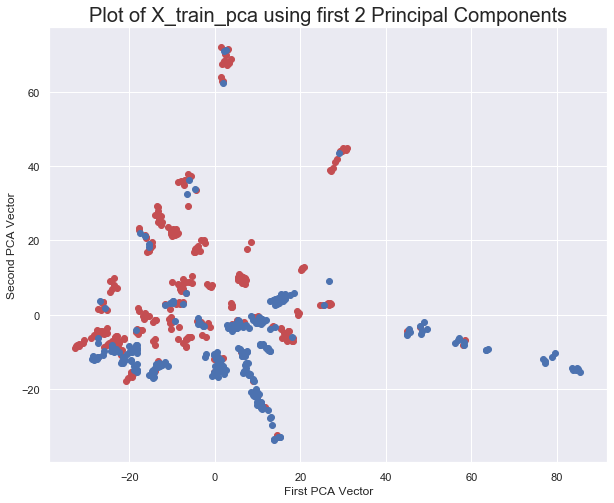

In [11]:
# plotting (following lab 8)

fig, ax = plt.subplots(figsize=(10,8))
# ax.scatter(X_train_pca[:,0], X_train_pca[:,1]);  # plotting w/ out colors

colors = ['r','b']
label_text = ["ALL", "AML"]

# loop over the 2 cancer types
for cur_class in [0,1]:
    cur_df = X_train_pca[y_train==cur_class]
    ax.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_class], label=label_text[cur_class])

ax.set_xlabel('First PCA Vector')
ax.set_ylabel('Second PCA Vector')
ax.set_title('Plot of X_train_pca using first 2 Principal Components', fontsize=20);

*Understanding the way that the first two components look like helps understand how easy it is to classify the two classes of cancer types. This gives us an idea of how the other components may be splitting the classes and a glimpse into the nature of the entire dataset.*

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

In [12]:
# determine and report explained variance
print("Variance explained in X_train based on the top 2 PCA vectors are {} and {}."
      .format(str(pca_transformer.explained_variance_[0]), str(pca_transformer.explained_variance_[1])))

Variance explained in X_train based on the top 2 PCA vectors are 448.55775836058166 and 352.6262261826472.


In [13]:
# determine and report how many PCA vectors are needed for 90% of variablity is explained
ratio = pca_transformer.explained_variance_ratio_

for i in range(len(np.cumsum(ratio))):
    if np.cumsum(ratio)[i] > 0.9 and np.cumsum(ratio)[i] < 0.901:
        ncomps_90 = i
ncomps_90

231

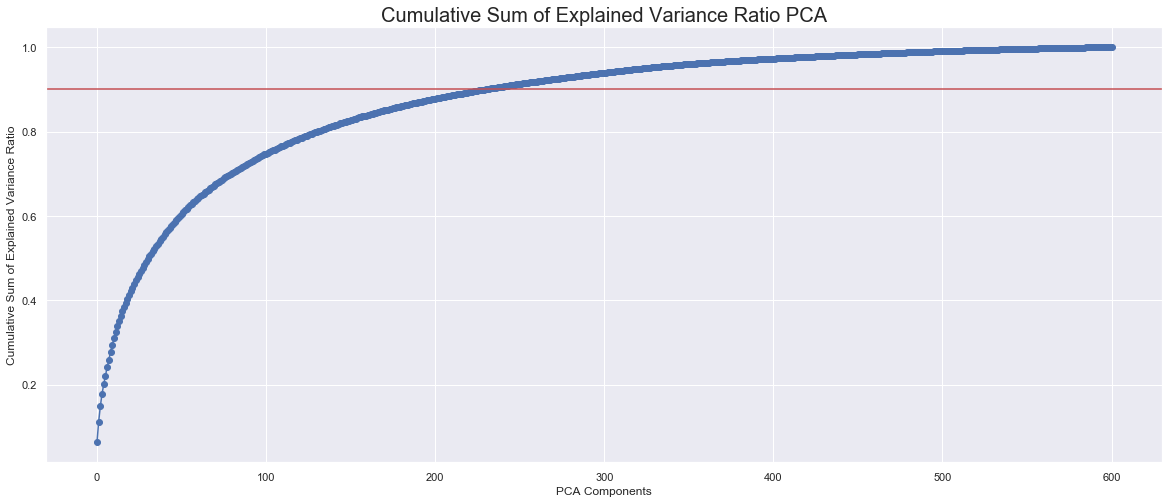

In [14]:
# determine and report # of PCA vectors needed for 90%
# following plots from section 6
fig, ax = plt.subplots(ncols=1, figsize=(20,8))

ax.plot(np.cumsum(ratio), 'o-')
ax.axhline(y=0.9, c='r')

ax.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax.set_xlabel("PCA Components")
ax.set_ylabel('Cumulative Sum of Explained Variance Ratio');

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice in 1-3 sentences.**

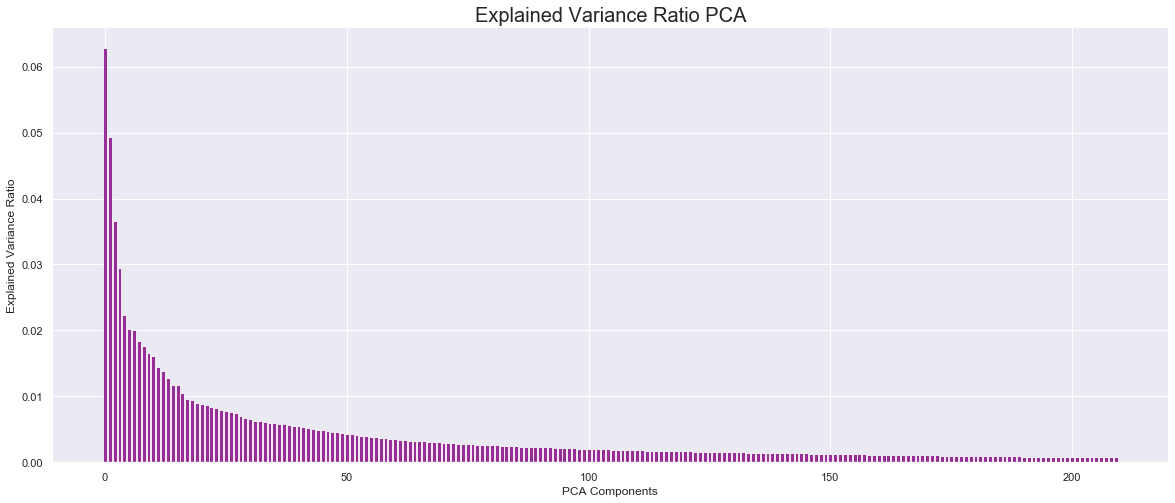

In [15]:
#following section 6
fig, ax = plt.subplots(ncols=1, figsize=(20,8))

ratio = pca_transformer.explained_variance_ratio_
ax.bar(range(len(ratio[0:210])), ratio[0:210], color='purple', alpha=0.8)
ax.set_title('Explained Variance Ratio PCA', fontsize=20)
ax.set_xlabel('PCA Components')
ax.set_ylabel('Explained Variance Ratio');

*I chose the number 25 because this seems to be around the value that the explained variance starts to shift to very small values.*

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [16]:
# fit model with first 2 pca vectors
# X_train_pca[:,0:2]
model_pca_2 = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 1000).fit(X_train_pca[:,0:2],y_train)

# Predict
y_pred_train_pca2 = model_pca_2.predict(X_train_pca[:,0:2])
y_pred_test_pca2 = model_pca_2.predict(X_test_pca[:,0:2])

# Score
train_score_pca2 = accuracy_score(y_train, y_pred_train_pca2)*100
test_score_pca2 = accuracy_score(y_test, y_pred_test_pca2)*100

print("Training Set Accuracy:",str(train_score_pca2)+'%')
print("Testing Set Accuracy:",str(test_score_pca2)+'%')

# fit model with 25 vectors
# X_train_pca[:,0:25]
model_pca_25 = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 10000).fit(X_train_pca[:,0:25],y_train)

# Predict
y_pred_train_pca25 = model_pca_25.predict(X_train_pca[:,0:25])
y_pred_test_pca25 = model_pca_25.predict(X_test_pca[:,0:25])

# Score
train_score_pca25 = accuracy_score(y_train, y_pred_train_pca25)*100
test_score_pca25 = accuracy_score(y_test, y_pred_test_pca25)*100

print("Training Set Accuracy:",str(train_score_pca25)+'%')
print("Testing Set Accuracy:",str(test_score_pca25)+'%')

# fit model with ncomps_90 vecors
# X_train_pca[:,0:ncomps_90]
model_pca_90 = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 10000).fit(X_train_pca[:,0:ncomps_90],y_train)

# Predict
y_pred_train_pca90 = model_pca_90.predict(X_train_pca[:,0:ncomps_90])
y_pred_test_pca90 = model_pca_90.predict(X_test_pca[:,0:ncomps_90])

# Score
train_score_pca90 = accuracy_score(y_train, y_pred_train_pca90)*100
test_score_pca90 = accuracy_score(y_test, y_pred_test_pca90)*100

print("Training Set Accuracy:",str(train_score_pca90)+'%')
print("Testing Set Accuracy:",str(test_score_pca90)+'%')

Training Set Accuracy: 75.87354409317804%
Testing Set Accuracy: 76.82119205298014%
Training Set Accuracy: 89.35108153078203%
Testing Set Accuracy: 85.43046357615894%
Training Set Accuracy: 100.0%
Testing Set Accuracy: 74.83443708609272%


*All these accuracies are lower than they were in question 1. This seems to imply that PCA yields worse prediction results. However, because it is such a large dataset, these more conservative values seem more plausible.*


**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [17]:
# use cross val score on first 2 components
# np.mean(cross_val_score(model_pca_2, X_train_pca, y_train, cv=5))
# use cross val score on 90% components
# np.mean(cross_val_score(model_pca_90, X_train_pca, y_train, cv=5))
# use cross val score on 210 components
# np.mean(cross_val_score(model_pca_210, X_train_pca, y_train, cv=5))

scores_2 = [np.mean(cross_val_score(model_pca_2, X_train_pca[:,0:2], y_train, cv=5)),
          np.mean(cross_val_score(model_pca_90, X_train_pca[:,0:ncomps_90], y_train, cv=5)),
          np.mean(cross_val_score(model_pca_25, X_train_pca[:,0:25], y_train, cv=5))]

components = [2, 25, ncomps_90]

# find which one is the best
best_score = 0
for i in range(len(scores_2)):
    if scores_2[i] > best_score:
        best_score = scores_2[i]
        index = components[i]

print("The best number of components is {} with a cross validation score of {}.".format(index, best_score))

# use section 6 to check relationship between cancer type and M31523_at (dot product)
vec1 = pca_transformer.components_[0]
vec2 = pca_transformer.components_[1]
print('The dot product between the first two principal components is ',np.round(np.dot(vec1, vec2),5))

The best number of components is 231 with a cross validation score of 0.8867699145774012.
The dot product between the first two principal components is  0.0


*Given that the dot product is 0 between the first two components, it seems like the model is based on a PCA training set that was defined correctly and has a pretty conservative cross validation score.*

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*ROC is trying to evaluate how useful a model is by checking its false positive rate against its tru positive rate. The AUC measures how well the model can differentiate between the two classes. Because these factors are more concrete and useful for, say, cancer types, it is more useful to use than missclassification rate.*

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [18]:
# follow lab 7
from sklearn.metrics import roc_curve, auc

# unregularized logisitic - pre-PCA
fpr1, tpr1, thresholds1=roc_curve(y_test, unreg_log.predict_proba(X_test)[:,1])
print("AUC for unregularized logistic model before PCA: \n",
      auc(fpr1, tpr1))

# regularized logistic - pre-PCA
fpr2, tpr2, thresholds2=roc_curve(y_test, reg_log_cv.predict_proba(X_test)[:,1])
print("AUC for regularized logistic model before PCA: \n",
      auc(fpr2, tpr2))

# k-NN - pre-PCA
fpr3, tpr3, thresholds3=roc_curve(y_test, best_knn.predict_proba(X_test)[:,1])
print("AUC for k-NN model before PCA: \n",
      auc(fpr3, tpr3))

# model_pca_2
fpr4, tpr4, thresholds4=roc_curve(y_test, model_pca_2.predict_proba(X_test_pca[:,0:2])[:,1])
print("AUC for logistic model with 2 principal components: \n",
      auc(fpr4, tpr4))

# model_pca_25
fpr5, tpr5, thresholds5=roc_curve(y_test, model_pca_25.predict_proba(X_test_pca[:,0:25])[:,1])
print("AUC for logistic model with 25 principal components: \n",
      auc(fpr5, tpr5))

# model_pca_90
fpr6, tpr6, thresholds6=roc_curve(y_test, model_pca_90.predict_proba(X_test_pca[:,0:ncomps_90])[:,1])
print("AUC for logistic model with 231 principal components: \n",
      auc(fpr6, tpr6))

AUC for unregularized logistic model before PCA: 
 0.847051597051597
AUC for regularized logistic model before PCA: 
 0.8634608634608635
AUC for k-NN model before PCA: 
 0.8680238680238681
AUC for logistic model with 2 principal components: 
 0.8218673218673219
AUC for logistic model with 25 principal components: 
 0.8480168480168482
AUC for logistic model with 231 principal components: 
 0.7875570375570374


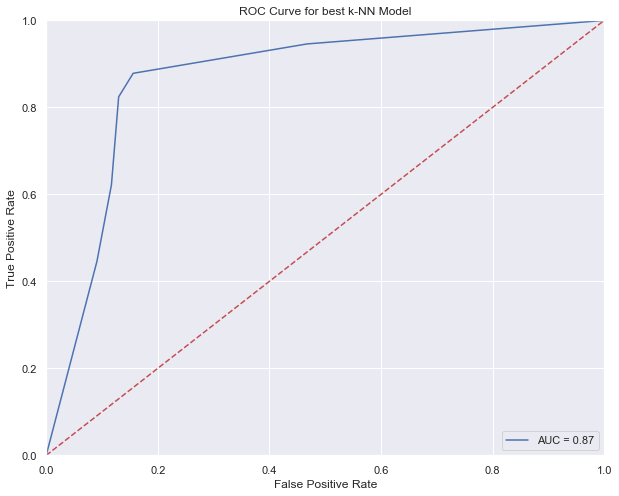

In [19]:
# best model was the knn model
# plotting
roc_auc = auc(fpr3, tpr3)

fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.set_title('ROC Curve for best k-NN Model')
ax.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate');
# plt.show()

*This ROC curve suggests that high true positice rates can be associated with low false positive rates which is indicates that the model is good at distinguishing the two classes without error.*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*Because the values are so close to each other, there is no clear winner. Depending on the serverity of the cancer and the type of treatment that could ensue, I would make my decision between the models taking those into account.*


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in train and test later.**

In [20]:
compas_df = pd.read_csv('data/compas.csv')

# process categorical predictors
# get dummies for c_charge_degree
compas_dummies_df =  pd.get_dummies(compas_df, 
                                    columns = ['c_charge_degree'],
                                    drop_first=False)
# recode the sex column
compas_dummies_df['sex'] = 1*(compas_df['sex']=='Male')
# dropping c_charge_desc because it had too many values that seemed unecessary
compas_dummies_df = compas_dummies_df.drop('c_charge_desc', axis = 1)
# splitting data with race as target
np.random.seed(10)
X_train_comp, X_test_comp, y_train_comp, y_test_comp =train_test_split(
                                                    compas_dummies_df.loc[:, compas_dummies_df.columns != 'race'], 
                                                    compas_df.race, test_size=0.2, 
                                                    random_state = 109, 
                                                    stratify = compas_df.race)

# X_train_comp.shape
# X_test_comp.shape
# y_train_comp.shape
# y_test_comp.shape

In [21]:
X_train_comp.head()

,age,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_F,c_charge_degree_M
37,29,Low,1,2,0,0,0,2,1,1,0,1,0,0,0,0,0,1,0,1,0,1
1721,30,Low,1,3,0,0,1,2,0,1,0,1,0,0,0,1,0,0,0,1,1,0
659,47,Low,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4682,54,Low,1,4,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,2,1,0
3845,22,Low,1,0,0,0,0,4,1,6,0,0,0,0,0,0,0,0,0,6,1,0


**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [22]:
# Perform t-tests to identify predictors

from scipy import stats  # for getting the p values

# reindex y_train first
# y_train_reindexed = y_train_comp.reset_index()

# split X train into the two classes - African-American and Caucasian
X_train_0 = X_train_comp.loc[y_train_comp[y_train_comp == 'African-American'].index.tolist()]
X_train_1 = X_train_comp.loc[y_train_comp[y_train_comp == 'Caucasian'].index.tolist()]

# construct t statistic by:
# substracting the means of the two from each other - this is the numerator of t
num = abs(X_train_0.mean()-X_train_1.mean())

# calculating the respective sample variances and divide by their respective Ns
var_0 = X_train_0.var()/len(X_train_0)
var_1 = X_train_1.var()/len(X_train_1)

# put it all together
t_stats = num/((var_0 + var_1)**(1/2))

# calculate the p values by:
# idenitifying degrees of freedom
dfs = len(X_train_0)+len(X_train_1) - 2

# using p_val = 1 - stats.t.cdf(t,df=df)
p_values = 1 - stats.t.cdf(t_stats,df=dfs)

# sort the pvalues and get the indices of the the smallest 3
indices = list(np.argsort(-t_stats.values)[0:3])

# store the names of the first 3 in its own list
best_3_predictors = X_train_comp.columns[indices]


print("The best three predictors are {}, {}, and {}.".format(best_3_predictors.tolist()[0],
                                                             best_3_predictors.tolist()[1],
                                                             best_3_predictors.tolist()[2]))

The best three predictors are juv_other_count, sex, and age.


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*The variables of juvenile history, sex, and age can easily play a role in causing statistically significant differences between African Americans and Caucasians. There may be clear systematic issues with juvenile disciplanary actions that may more negatively affect African American children. Sexism can very easily play a role as young, black females are almost always very negatively stereotyped as are young, black males as compared to their white counterparts. Age may also play a role and can easily be related to sex in this case as many studies show that black children are seen as more mature than their white counterparts and can easily be blamed for things disproportionately and tried as adults more often.*

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [23]:
# create new X_train include race, drop two_year_recid; create new y_train with two_year_recid as target
X_train_new = X_train_comp.drop('two_year_recid', axis=1)
X_train_new = X_train_new.drop('score_text', axis=1)
X_train_new['race'] = 1*(compas_dummies_df['race'] == 'African-American')  #include race as a predictor; 1 if AA, 0 if Cauc
y_train_new = X_train_comp['two_year_recid']

# create new X_test
X_test_new = X_test_comp.drop('two_year_recid', axis=1)
X_test_new = X_test_new.drop('score_text', axis=1)
X_test_new['race'] = 1*(compas_dummies_df['race'] == 'African-American')  #include race as a predictor; 1 if AA, 0 if Cauc
y_test_new = X_test_comp['two_year_recid']


# logistic model
model_44_log = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 1000).fit(X_train_new,y_train_new)
y_test_new_pred_log = model_44_log.predict(X_test_new)

# k-NN model
model_44_k = KNeighborsClassifier(10)
model_44_k.fit(X_train_new,y_train_new)
y_test_new_pred_k = model_44_k.predict(X_test_new)

**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [24]:
# refit the models, drop race
# create new X_train drop race
X_train_new2 = X_train_new.drop('race', axis=1)
# create new X_train drop race
X_test_new2 = X_test_new.drop('race', axis=1)

# logistic model
model_44_log2 = LogisticRegression(C=100000, solver = "lbfgs", max_iter = 1000).fit(X_train_new2,y_train_new)
y_test_new_pred_log2 = model_44_log2.predict(X_test_new2)

# k-NN model
model_44_k2 = KNeighborsClassifier(10)
model_44_k2.fit(X_train_new2,y_train_new)
y_test_new_pred_k2 = model_44_k2.predict(X_test_new2)

# confusion matrices :))
# Calculate Confusion Matrix for log1 and FPR and FNR
cm_log = confusion_matrix(y_test_new,y_test_new_pred_log)
fpr_log = cm_log[0,1]/(cm_log[0,1] + cm_log[0,0])*100  # FP/(FP + TN)  or 0,1/(0,1 + 0,0)
fnr_log = cm_log[1,0]/(cm_log[1,0] + cm_log[1,1])*100  # FN/(FN + TP)  or 1,0/(1,0 + 1,1)
print("Logistic Regression with race: \n {} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_log, fpr_log, fnr_log))

# Calculate Confusion Matrix kNN1 then get confusion matrix and FPR and FNR
cm_k1 = confusion_matrix(y_test_new,y_test_new_pred_k)
fpr_k1 = cm_k1[0,1]/(cm_k1[0,1] + cm_k1[0,0])*100
fnr_k1 = cm_k1[1,0]/(cm_k1[1,0] + cm_k1[1,1])*100
print("KNN Classifier with race: \n{} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_k1, fpr_k1, fnr_k1))

# Calculate Confusion Matrix for log2 and FPR and FNR
cm_log2 = confusion_matrix(y_test_new,y_test_new_pred_log2)
fpr_log2 = cm_log2[0,1]/(cm_log2[0,1] + cm_log2[0,0])*100
fnr_log2 = cm_log2[1,0]/(cm_log2[1,0] + cm_log2[1,1])*100 
print("Logistic Regression without race: \n{} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_log2, fpr_log2, fnr_log2))

# Caluculate Confusion Matrix for knn2
cm_k2 = confusion_matrix(y_test_new,y_test_new_pred_k2)
fpr_k2 = cm_k2[0,1]/(cm_k2[0,1] + cm_k2[0,0])*100
fnr_k2 = cm_k2[1,0]/(cm_k2[1,0] + cm_k2[1,1])*100
print("KNN Classifier without race: \n{} \n False Postive Rate: {}% \n False Negative Rate: {}%"
      .format(cm_k2, fpr_k2, fnr_k2))

Logistic Regression with race: 
 [[516 161]
 [228 330]] 
 False Postive Rate: 23.78138847858198% 
 False Negative Rate: 40.86021505376344%
KNN Classifier with race: 
[[542 135]
 [280 278]] 
 False Postive Rate: 19.940915805022154% 
 False Negative Rate: 50.179211469534046%
Logistic Regression without race: 
[[514 163]
 [228 330]] 
 False Postive Rate: 24.076809453471196% 
 False Negative Rate: 40.86021505376344%
KNN Classifier without race: 
[[540 137]
 [282 276]] 
 False Postive Rate: 20.236336779911372% 
 False Negative Rate: 50.53763440860215%


*It seems that, withouth race, the models tend to perform more poorly. This would suggest that race may be an important factor to consider when trying to predict recidivism which would imply that some racist policy or ideation is being reflected here.*

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*Given my exploration, I do not think that a predictive tool should be trusted to be unbiased. No matter how automated an algorithm is, it cannot erase systematic issues that are a result of human policy making. Bias can still occur in other parts of the justice system which an algorithm will undoub*


---